In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
df = pd.read_csv("customer_segmentation_data_clean.csv")
df.head()

,minutes_watched,clv,region_western_europe,region_anglosphere,region_rest,channel_facebook,channel_friend,channel_google,channel_instagram,channel_linkedin,channel_other,channel_twitter,channel_youtube
0,3197.0,205.42,0,0,1,0,0,0,0,1,0,0,0
1,63.0,149.99,0,1,0,0,0,1,0,0,0,0,0
2,605.0,119.00,0,0,1,1,0,0,0,0,0,0,0
3,20.0,240.00,0,0,1,0,0,0,0,1,0,0,0
4,245.0,184.36,1,0,0,0,0,0,0,1,0,0,0


# Data Standardization

Prior the hierarchical clustering and k-means, we need to standardize the data. Without it, our results would be unrealible and skewed, specially considering the difference in magnitude regarding minutes watched versus CLV. 

In [3]:
cols_to_std = ["minutes_watched", "clv"]

num_pipe = Pipeline([
    #("log1p", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, cols_to_std),
        #('scaler', RobustScaler(), cols_to_std),
        ("passthrough", "passthrough", [col for col in df if col not in cols_to_std])
    ],verbose_feature_names_out=False,
)
preprocessor.set_output(transform="pandas")
df_scaled = preprocessor.fit_transform(df)

In [4]:
df_scaled.head()

,minutes_watched,clv,region_western_europe,region_anglosphere,region_rest,channel_facebook,channel_friend,channel_google,channel_instagram,channel_linkedin,channel_other,channel_twitter,channel_youtube
0,0.175425,1.235219,0,0,1,0,0,0,0,1,0,0,0
1,-0.253766,0.448554,0,1,0,0,0,1,0,0,0,0,0
2,-0.179541,0.008743,0,0,1,1,0,0,0,0,0,0,0
3,-0.259655,1.725979,0,0,1,0,0,0,0,1,0,0,0
4,-0.228842,0.936335,1,0,0,0,0,0,0,1,0,0,0


# Hierarchical clustering

After the data standardization is complete, we can finally utilize clustering the data. Let's start by using the `Ward` method. 

In [5]:
hier_clust = linkage(df_scaled, method='ward')

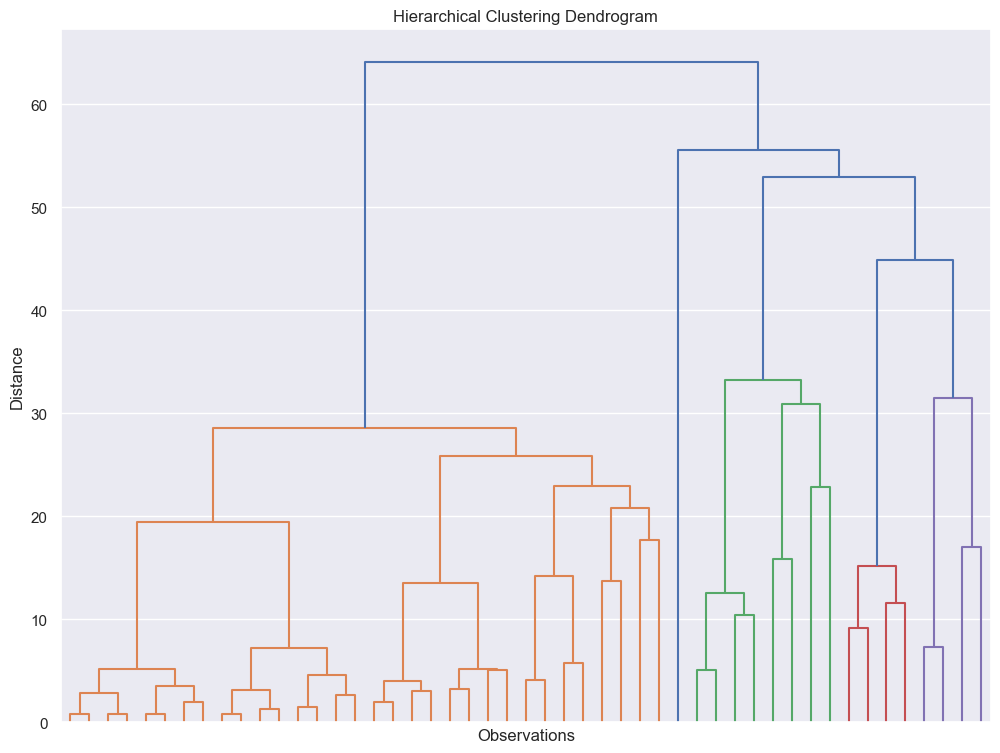

In [6]:
plt.figure(figsize=(12,9))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hier_clust, truncate_mode="level", p=5, show_leaf_counts=False, no_labels=True)
plt.show()

The result of the algorithm points to 4 separate clusters.

# K-Means Clustering

Now let's try with the K-means clustering algorithm, we'll perform an iteration with 10 steps, utilizing k-means++ as the initializer.

In [7]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,
                    init="k-means++",
                    random_state=42)

    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

Plot the results to see if the elbow can be spotted:

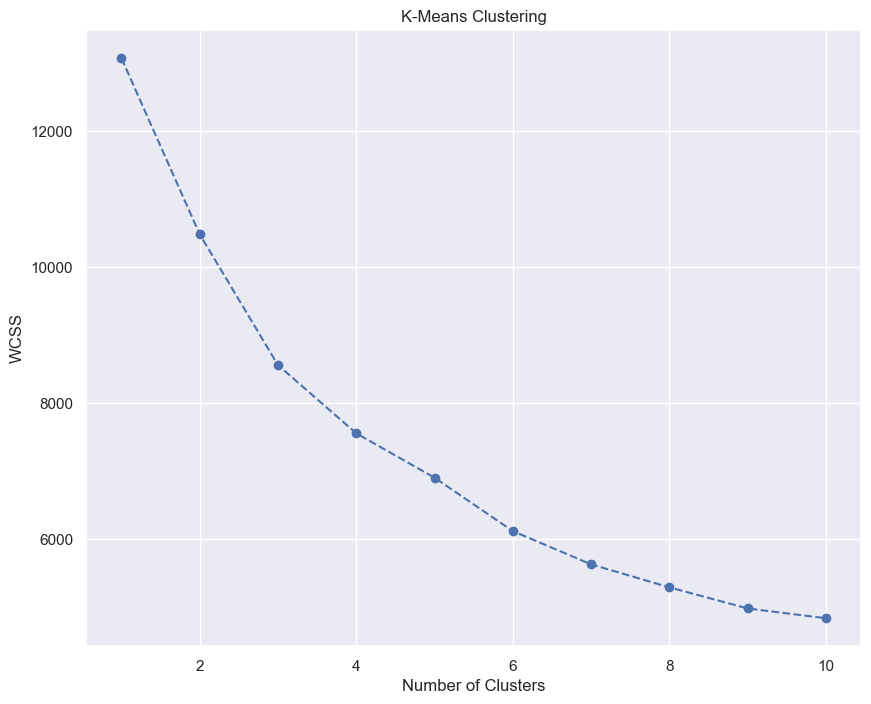

In [8]:
plt.figure(figsize=(10,8))
plt.plot(range(1, 11), wcss, marker="o", linestyle="--")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("K-Means Clustering")
plt.show()

### Choosing *k*


**WCSS always decreases** as *k* grows → the “elbow” is **subjective** and may be weak/ambiguous. It measures compactness but not **separation** between clusters. I will hence complement the elbow with **objective internal indices**.


- I'll sweep *k = 2…7* (around the elbow) and fit `KMeans` (many initializations for stability).
- For each *k*, compute **internal validation metrics** and the **smallest cluster size**:
  - **Silhouette** (higher values are better): average cohesion–separation score in \[-1, 1\].
  - **Calinski–Harabasz** (higher values are better): between- vs within-cluster dispersion ratio.
  - **Davies–Bouldin** (lower values are better): average similarity to the most similar cluster.
  - **min_cluster_size**: guards against tiny, impractical segments.

**Why these metrics are good**
- They don’t require labels (unsupervised).
- They balance **compactness** (tight clusters) and **separation** (distinct clusters).
- They provide **quantitative** evidence to choose *k*, reducing elbow subjectivity.

**How we’ll decide from the table**
1. Prefer the *k* with **highest Silhouette** and **lowest Davies–Bouldin** (primary).
2. Use **Calinski–Harabasz** as a tie-breaker (higher is better; often favors smaller *k*).
3. Ensure **min_cluster_size** is reasonable (avoid tiny shards).
4. If metrics disagree, pick the **simpler** of close contenders and confirm:
   - stability across random seeds,
   - clear business interpretation of segment profiles.

*Result: a defensible, data-driven choice of the number of clusters, not just a visual guess from WCSS.*


In [9]:
from sklearn.cluster import KMeans

rows = []
for k in range(2, 8):  # focus around the elbow
    km = KMeans(n_clusters=k, n_init=50, random_state=0)
    labels = km.fit_predict(df_scaled)  # your preprocessed features
    rows.append({
        "k": k,
        "silhouette": silhouette_score(df_scaled, labels),
        "calinski_harabasz": calinski_harabasz_score(df_scaled, labels),
        "davies_bouldin": davies_bouldin_score(df_scaled, labels),
        "min_cluster_size": pd.Series(labels).value_counts().min()
    })

pd.DataFrame(rows).set_index("k")


,silhouette,calinski_harabasz,davies_bouldin,min_cluster_size
k,,,,
2,0.232161,947.418998,1.645726,1902
3,0.236596,1010.604801,1.254955,6
4,0.234490,932.428365,1.355959,6
5,0.242609,917.089836,1.165485,1
6,0.228401,902.988000,1.242305,1
7,0.235908,870.368285,1.191247,1


According to this, the best split would be with 5 clusters.

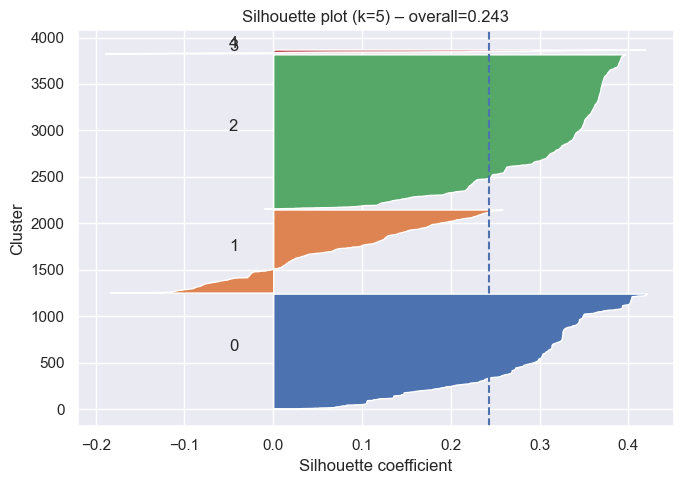

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import matplotlib.pyplot as plt

k = 5
km = KMeans(n_clusters=k, n_init=50, random_state=0).fit(df_scaled)
labels = km.labels_

samp = silhouette_samples(df_scaled, labels)
overall = silhouette_score(df_scaled, labels)

fig, ax = plt.subplots(figsize=(7,5))
y_lower = 10
for c in range(k):
    vals = np.sort(samp[labels == c])
    size = vals.shape[0]
    y_upper = y_lower + size
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, vals)
    ax.text(-0.05, y_lower + 0.5*size, str(c))
    y_lower = y_upper + 10

ax.axvline(overall, linestyle="--")
ax.set_xlabel("Silhouette coefficient")
ax.set_ylabel("Cluster")
ax.set_title(f"Silhouette plot (k={k}) – overall={overall:.3f}")
plt.tight_layout()


### Decision: proceed with **5 clusters**

**Why (from the silhouette plot):**
- **Overall silhouette ≈ 0.243** — acceptable for real customer data.
- **Most samples have positive silhouette** in every cluster; only a small negative tail (mainly in cluster **0**) → few badly placed points.
- **Bands are reasonably wide** across clusters → segments aren’t thin shards; sizes are practical.
- Together with earlier metrics (highest **silhouette**, lowest **Davies–Bouldin** around *k=5*), this supports **k=5**.

In [11]:

kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans.fit(df_scaled)

,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


# Model Evaluation

In [12]:
# Creating a copy of the original dataframe to avoid modifying it directly.
df_segmented = df.copy()

# Assigning the cluster labels generated by k-means to a new column named 'Segment' in the copied dataframe.
#df_segmented['hc_labels'] = fcluster(Z=hier_clust, t=4, criterion="maxclust")
df_segmented['km_labels'] = kmeans.labels_
df_segmented.head()

,minutes_watched,clv,region_western_europe,region_anglosphere,region_rest,channel_facebook,channel_friend,channel_google,channel_instagram,channel_linkedin,channel_other,channel_twitter,channel_youtube,km_labels
0,3197.0,205.42,0,0,1,0,0,0,0,1,0,0,0,0
1,63.0,149.99,0,1,0,0,0,1,0,0,0,0,0,1
2,605.0,119.00,0,0,1,1,0,0,0,0,0,0,0,0
3,20.0,240.00,0,0,1,0,0,0,0,1,0,0,0,0
4,245.0,184.36,1,0,0,0,0,0,0,1,0,0,0,1


In [13]:
# Grouping the dataframe by the 'cluster_labels' column and calculating the mean for each segment.
# This provides a profile for each cluster based on the mean values of the original features.
df_segm_analysis = df_segmented.groupby(['km_labels']).mean()
df_segm_analysis

,minutes_watched,clv,region_western_europe,region_anglosphere,region_rest,channel_facebook,channel_friend,channel_google,channel_instagram,channel_linkedin,channel_other,channel_twitter,channel_youtube
km_labels,,,,,,,,,,,,,
0,1507.378378,146.874310,0.000000,0.000000,1.000000,0.085349,0.149360,0.152205,0.068279,0.197724,0.064011,0.011380,0.271693
1,897.564528,146.237001,0.231435,0.768565,0.000000,0.069214,0.094448,0.173756,0.080029,0.151406,0.097332,0.008652,0.325162
2,132411.166667,266.546667,0.000000,0.333333,0.666667,0.166667,0.166667,0.000000,0.000000,0.166667,0.166667,0.000000,0.333333
3,1613.278141,55.012723,0.051702,0.139398,0.808901,0.090314,0.144634,0.178010,0.075916,0.181937,0.059555,0.023560,0.246073
4,8485.176190,295.913667,0.290476,0.404762,0.304762,0.052381,0.095238,0.242857,0.066667,0.104762,0.076190,0.009524,0.352381


In [14]:
# Counting the number of observations in each segment.
# This is done by grouping by 'Segment' and counting the occurrences.
# 'region_rest' is used arbitrarily to count, as it exists in each segment.
df_segm_analysis['n'] = df_segmented[['km_labels','region_rest']].groupby(['km_labels']).count()

# Calculating the proportion of observations in each segment.
# This is done by dividing the number of observations in a segment by the total number of observations.
df_segm_analysis['proportion'] = df_segm_analysis['n'] / df_segm_analysis['n'].sum()
df_segm_analysis

,minutes_watched,clv,region_western_europe,region_anglosphere,region_rest,channel_facebook,channel_friend,channel_google,channel_instagram,channel_linkedin,channel_other,channel_twitter,channel_youtube,n,proportion
km_labels,,,,,,,,,,,,,,,
0,1507.378378,146.874310,0.000000,0.000000,1.000000,0.085349,0.149360,0.152205,0.068279,0.197724,0.064011,0.011380,0.271693,703,0.183359
1,897.564528,146.237001,0.231435,0.768565,0.000000,0.069214,0.094448,0.173756,0.080029,0.151406,0.097332,0.008652,0.325162,1387,0.361763
2,132411.166667,266.546667,0.000000,0.333333,0.666667,0.166667,0.166667,0.000000,0.000000,0.166667,0.166667,0.000000,0.333333,6,0.001565
3,1613.278141,55.012723,0.051702,0.139398,0.808901,0.090314,0.144634,0.178010,0.075916,0.181937,0.059555,0.023560,0.246073,1528,0.398539
4,8485.176190,295.913667,0.290476,0.404762,0.304762,0.052381,0.095238,0.242857,0.066667,0.104762,0.076190,0.009524,0.352381,210,0.054773


## Cluster segmentation — names, profiles, and quick takeaways

**C0 — ROW Professionals · Mid-High Engagement & CLV**
- **Size:** ~18% (n≈703)  
- **Profile:** **minutes ≈ 1.5k**, **CLV ≈ 147**.  
- **Mix:** **100% Rest of World**.  
- **Acquisition:** **YouTube (~27%)** and **LinkedIn (~20%)** lead.  
- **Takeaway:** Good value in ROW via professional channels → double-down on LinkedIn + localized offers.

**C1 — Anglosphere Regulars · Mid CLV**
- **Size:** ~36% (n≈1,387)  
- **Profile:** **minutes ≈ 900**, **CLV ≈ 146**.  
- **Mix:** **Anglosphere-dominant (~77%)** (+ some Western Europe).  
- **Acquisition:** **YouTube (~33%)**, then Google (~17%), LinkedIn (~15%).  
- **Takeaway:** Solid revenue with moderate engagement → upsell to higher tiers; content tuned to Anglosphere.

**C2 — VIP Outliers / Power Buyers (inspect)**
- **Size:** ~0.2% (n=6)  
- **Profile:** **minutes ≈ 132k** (~92 days) and **CLV ≈ 267**.  
- **Mix & Channels:** ROW/Anglosphere mix; YouTube prominent.  
- **Takeaway:** Tiny “VIP/exceptions” cluster. **Audit for data quality**; if real, treat as VIP cohort; otherwise cap/remove and re-fit.

**C3 — Browsers · Low Value (ROW)**
- **Size:** ~40% (n≈1,528)  
- **Profile:** **minutes_watched ≈ 1.6k** (engaged) but **CLV ≈ 55** (very low).  
- **Mix:** Heavily **Rest of World (~81%)**.  
- **Acquisition:** YouTube (~25%), Google/LinkedIn (~18% each).  
- **Takeaway:** Large under-monetized cohort → test pricing, bundles, trial-to-paid nudges.

**C4 — Premium Enthusiasts · High CLV**
- **Size:** ~5.5% (n≈210)  
- **Profile:** **minutes ≈ 8.5k**, **CLV ≈ 296** (highest).  
- **Mix:** Mixed (**Anglosphere ~40%**, **W. Europe ~29%**, **ROW ~30%**).  
- **Acquisition:** **YouTube (~35%)**, **Google (~24%)**.  
- **Takeaway:** High-value power segment → retention perks, certificates, referrals.


**Cross-cluster notes**
- **YouTube** is the top source in every meaningful segment.
- Region matters: **ROW** dominates low-value Browsers (C3) and a sizeable mid-value group (C0); **Anglosphere** drives a strong mid-CLV segment (C1).
- For actionability, build “cluster cards” and track CAC/ROI by **channel × segment** before reallocating budget.
